In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# # using DiffEqFlux
# # using Optim
# using ForwardDiff
using DelimitedFiles

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [3]:
function limit_func(param,pmin,pmax)
    if pmin < param < pmax
        return param
    elseif param <= pmin
        return pmin
    else
        return pmax
    end
end

function alpha(p, t)
    Tₐ = 10#limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = 0.7#limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

# dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = 10#limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = 2#limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

# dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

pulse (generic function with 1 method)

In [4]:
p1 = [2.0,
10.0,
10.0,
 0.7,
 0.5418,
 2.4237061150395447,
 3.44314831140435,
 3.1258846903218442,
 0.05289]

p2 = [2.0,
10.0,
10.0,
 0.7,
 1.8410836437809366,
 2.4788560906225645,
 3.527526663435302,
 3.1258846903218442,
-0.27721491876638443] ;

In [176]:
G1 = ψ1s'*sol1.u[end]
G2 = ψ1s'*sol2.u[end]

angles = angle.(ψ1s'*sol1.u[end])
sig_phi = 0.5 * (angles[2,1] - angles[1,2])
sig_x = zeros(ComplexF64,2,2)
sig_x[1,2] = exp(-im*sig_phi)
sig_x[2,1] = exp(im*sig_phi)
sig_y = zeros(ComplexF64,2,2)
sig_y[1,2] = -im * exp(-im*sig_phi)
sig_y[2,1] = im * exp(im*sig_phi)

1 - 0.25 * abs2(tr(G1'*sig_x)), 0.5*(2 - abs2(G1[1,2]) - abs2(G1[2,1])),
1 - 0.25 * abs2(tr(G2'*sig_y))/0.5*(2 - abs2(G2[1,2]) - abs2(G2[2,1]))

(2.9051193432882982e-5, 2.9051192233231493e-5, 0.9998305927886012)

In [161]:
# 2.4788560906225645/real(E07s[2] - E07s[1])
3.527526663435302*abs(ψ07s[:,2]'*chargecoupling*ψ07s[:,1])

1.0404474783885194

In [5]:
E1s, ψ1s = eigs(KinPot12 + Potential3, nev=2, which=:SR)
times = LinRange(0,30,1000) ;

In [10]:
dE

-77.69610689320984

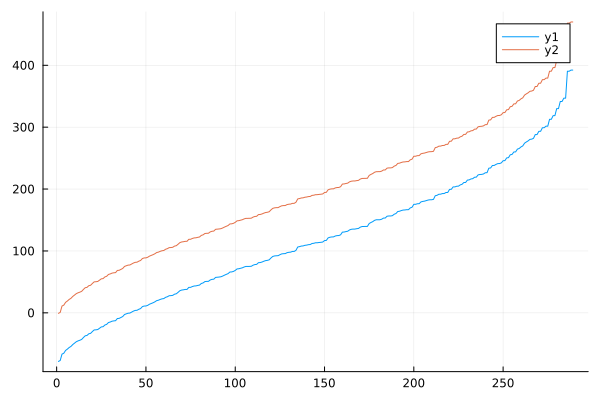

In [19]:
dE = real(E1s[2] + E1s[1])/2
plot(eigvals(Matrix(KinPot12+Potential3)))
plot!(eigvals(Matrix(KinPot12+Potential3 - dE .* kron(Id,Id))))

In [171]:
shift = dE .* kron(Id,Id)
function f!(du, u, p, t)
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling# + shift
    du[:] = - im .* (H * u)
end

forward_prob = ODEProblem(f!, ψ1s[:,1:2], (0.0, 30.0), p1)
sol1 = solve(forward_prob, p=p1, saveat=times, reltol=1e-10, abstol=1e-10)

forward_prob = ODEProblem(f!, ψ1s[:,1:2], (0.0, 30.0), p2)
sol2 = solve(forward_prob, p=p2, saveat=times, reltol=1e-10, abstol=1e-10)
;

In [27]:
sigz = [1 0 ; 0 -1]
sigx = [0 1 ; 1 0]
sigy = [0 -im ; im 0]

2×2 Matrix{Complex{Int64}}:
 0+0im  0-1im
 0+1im  0+0im

In [28]:
exp1 = zeros(ComplexF64,1000,3)
exp2 = zeros(ComplexF64,1000,3)
past = copy(ψ1s)
for (i, t) in enumerate(times)
    tmpEs, tmpψs = eigs(KinPot12 + alpha(p1,t) .* Potential3, nev=2, which=:SR)

    tmpψs = exp.(im.*angle.(diag(past'*tmpψs)))'.*tmpψs

    ψ = tmpψs'*sol1.u[i][:,1]
    # ψ = sol1.u[i][:,1]

    # angles = angle.(past'*tmpψs)
    # sig_phi = 0.5 * (angles[2,2] - angles[1,1])
    # sig_x = zeros(ComplexF64,2,2)
    # sig_x[1,2] = exp(-im*sig_phi)
    # sig_x[2,1] = exp(im*sig_phi)

    # sig_y = zeros(ComplexF64,2,2)
    # sig_y[1,2] = -im * exp(-im*sig_phi)
    # sig_y[2,1] = im * exp(im*sig_phi)

    # sig_x = tmpψs[:,1]*tmpψs[:,2]' + tmpψs[:,2]*tmpψs[:,1]'
    # sig_y = -im .* tmpψs[:,1]*tmpψs[:,2]' + im .* tmpψs[:,2]*tmpψs[:,1]'
    # sig_z = tmpψs[:,1]*tmpψs[:,1]' - tmpψs[:,2]*tmpψs[:,2]'

    exp1[i,1] = ψ'*sigx*ψ #* cos(real(tmpEs[1] - tmpEs[2])*t)
    exp1[i,2] = ψ'*sigy*ψ #* sin(real(tmpEs[1] - tmpEs[2])*t)
    exp1[i,3] = ψ'*sigz*ψ

    ψ = tmpψs'*sol2.u[i][:,1]

    exp2[i,1] = ψ'*sigx*ψ #* cos(real(tmpEs[1] - tmpEs[2])*t)
    exp2[i,2] = ψ'*sigy*ψ #* sin(real(tmpEs[1] - tmpEs[2])*t)
    exp2[i,3] = ψ'*sigz*ψ

    past = copy(tmpψs)
end
exp1 = real.(exp1)
exp2 = real.(exp2)

1000×3 Matrix{Float64}:
 -1.22235e-13  -1.83854e-13   1.0
 -0.000315717   0.000457499   0.999998
 -0.000613756   0.000934974   0.999994
 -0.000893109   0.00143167    0.999988
 -0.00115279    0.00194674    0.999981
 -0.00139183    0.00247921    0.999976
 -0.00160937    0.00302796    0.999974
 -0.00180468    0.00359175    0.999974
 -0.00197728    0.00416925    0.999975
 -0.00212693    0.0047592     0.999978
  ⋮                          
  0.00333942   -0.00317548   -0.999949
  0.00283543   -0.00283229   -0.999956
  0.00235384   -0.00247659   -0.999963
  0.00189718   -0.00210787   -0.999968
  0.00146702   -0.00172488   -0.999971
  0.00106374   -0.00132625   -0.999972
  0.00068655   -0.000910999  -0.99997
  0.000333836  -0.000479128  -0.999968
  3.69933e-6   -3.18359e-5   -0.999966

In [123]:
E07s, ψ07s = eigs(KinPot12 + 0.7 .* Potential3, nev=2, which=:SR)
w0 = 0.9985.*real(E07s[2] - E07s[1])
# plot(exp1[:,1].*cos.(w0*times))

2.47881855563552

In [122]:
2.4788560906225645/real(E07s[2] - E07s[1])

0.9985151195754969

In [132]:
# function rotate(exp,w0=w0)
#     mask = 333:666
#     (exp[:,1].*cos.(w0*times) - exp[:,2].*sin.(w0*times))[mask],
#     (exp[:,2].*cos.(w0*times) + exp[:,1].*sin.(w0*times))[mask]
#     # exp[:,3][mask]
# end
function rotate(exp,w0=w0)
    mask = 333:666
    (exp[:,1].*cos.(w0*times) - exp[:,2].*sin.(w0*times))[mask],
    (exp[:,2].*cos.(w0*times) + exp[:,1].*sin.(w0*times))[mask]
    # exp[:,3][mask]
end

rotate (generic function with 2 methods)

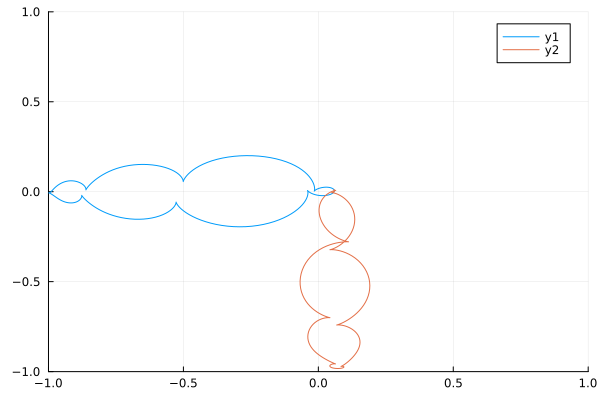

In [133]:
# plot(exp2[:,1].*cos.(w0*times)-,exp2[:,2].*sin.(w0*times),exp2[:,3])
plot(rotate(exp2,w0),xlim=(-1,1),ylim=(-1,1),zlim=(-1,1))
plot!(rotate(exp1,w0))
# plot(exp2[:,1],exp2[:,2],exp2[:,3])
# plot!(exp1[:,1],exp1[:,2],exp1[:,3])

In [160]:
tmpEs, tmpψs = eigs(KinPot12 + 0.7 .* Potential3, nev=2, which=:SR)
tmpEs[2] - tmpEs[1]

2.4825423691894457 + 4.693646447230367e-16im

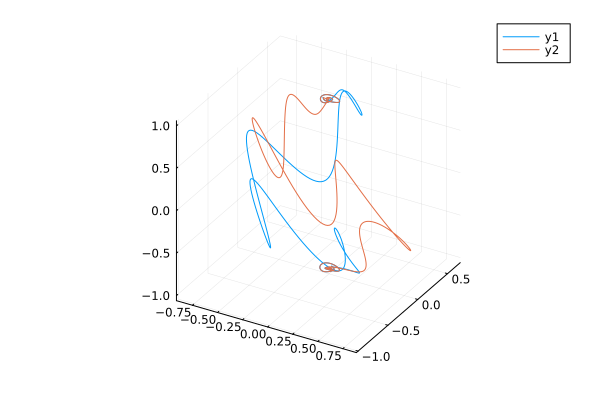

In [157]:
surface(sphere(0.99,[0,0,0]),transparency = true)
plot([exp1[:,1].*cos.(real(E1s[1] - E1s[2])*times),exp2[:,1].*cos.(real(E1s[1] - E1s[2])*times)],
     [exp1[:,2].*sin.(real(E1s[1] - E1s[2])*times),exp2[:,2].*sin.(real(E1s[1] - E1s[2])*times)],
     [exp1[:,3],exp2[:,3]],
     # camera = (0,90)
     )

In [45]:
function sphere(r, C)   # r: radius; C: center [cx,cy,cz]
    n = 100
    u = range(-π, π; length = n)
    v = range(0, π; length = n)
    x = C[1] .+ r*cos.(u) * sin.(v)'
    y = C[2] .+ r*sin.(u) * sin.(v)'
    z = C[3] .+ r*ones(n) * cos.(v)'
    return x, y, z
end

sphere (generic function with 1 method)

In [155]:
# writedlm("exp1.txt",exp1)
# writedlm("exp2.txt",exp2)

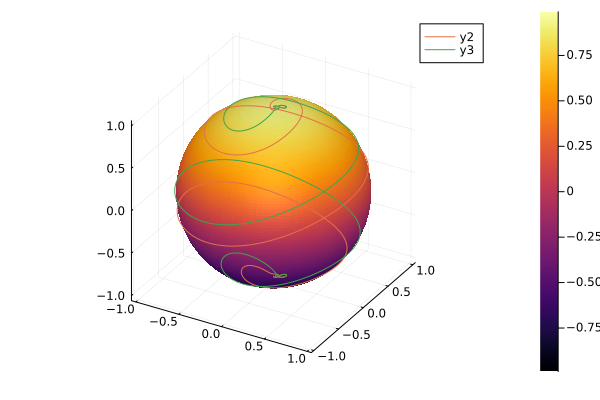

In [52]:
surface(sphere(0.99,[0,0,0]),transparency = true)
plot!([exp1[:,1],exp2[:,1]],
     [exp1[:,2],exp2[:,2]],
     [exp1[:,3],exp2[:,3]],
     # exp2[:,1].*cos.(-w0*times),exp2[:,2].*sin.(-w0*times),exp2[:,3],
     # camera=(0,45)
     )

     
# surface(sphere(0.9,[0,0,0]),transparency = true,colormap = [(:blue, 0.5), (:green, 0.5)])

In [149]:
mask = 334:667
gauge = angle((ψ07s'*sol1.u[334])[1,1])#,ψ07s'*sol2.u[334]
exp(-im*gauge)*(ψ07s'*sol1.u[334])[1,1]

0.9995344589808601 + 1.1102230246251565e-16im